In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from PIL import Image, ImageEnhance, ImageStat
from tensorflow.keras.backend import binary_crossentropy

#!rm -rf ./logs/

%load_ext pycodestyle_magic
LEARNING_RATE = 1e-4
IMAGE_PX = 128

In [2]:
%flake8_on --max_line_length 115

def weighted_bce_dice_loss(y_true, y_pred):
    return tf.reduce_sum(tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, 10))


def dice_coef_loss(y_true, y_pred, smooth=1, weight=0.5):
    y_true = tf.squeeze(y_true)
    y_pred = tf.squeeze(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + weight * tf.reduce_sum(y_pred)
    return 1 - ((2. * intersection + smooth) / (union + smooth))


def weighted_bce_dice_loss(y_true, y_pred):
    class_loglosses = tf.reduce_mean(binary_crossentropy(y_true, y_pred),
                                     axis=[0, 1, 2])

    class_weights = [0.1, 0.9]
    weighted_bce = tf.reduce_sum(class_loglosses * class_weights)
    return weighted_bce + 0.5 * (dice_coef_loss(y_true, y_pred))


# model.save('./model.save')
model = tf.keras.models.load_model('./model.save', compile=False)

In [3]:
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=weighted_bce_dice_loss,
              metrics=['accuracy'])

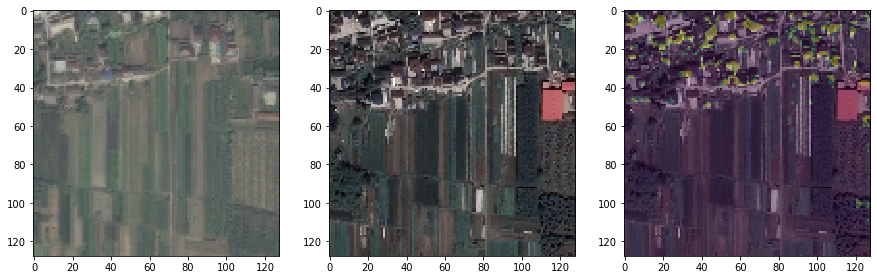

In [4]:
a_path = './test_set/5/Before.png'
b_path = './test_set/5/After.png'

def prepare_image(path, channels):
    res = tf.image.decode_png(tf.io.read_file(path), channels=channels)
    res = tf.image.convert_image_dtype(res, tf.float32)
    return tf.image.resize(res, [IMAGE_PX, IMAGE_PX])


a = prepare_image(a_path, 3)
b = prepare_image(b_path, 3)

x = concatenate([a, b], axis=2)

x = x[tf.newaxis, ...]

pred = tf.squeeze(model.predict(x)[0])

plt.figure(figsize=(15, 45))

plt.subplot(131)
plt.imshow(a)


plt.subplot(132)
plt.imshow(b)

plt.subplot(133)
plt.imshow(b, alpha=1)
plt.imshow(pred, alpha=0.3)